[Ref](https://medium.com/geekculture/stroke-prediction-d26c15f9d1)

# Giới thiệu
Theo Tổ chức Y tế thế giới (WHO), đột quỵ là lý do đứng thứ 2 gây ra tử vong và lý do đứng thứ 3 gây ra khuyết tật trên toàn cầu. Đột quỵ là hiện tượng chết đột ngột tế bào não do việc thiếu oxy khi lượng máu lên não bị mất đi do tắc nghẽn hoặc vỡ động mạch lên não. Đây cũng là nguyên nhân hàng đầu dẫn đến sa sút trí tuệ và trầm cảm. <br/>

Gần 800 nghìn người ở Mỹ trải qua 1 cơn đột quỵ mỗi năm, trong đó khoảng 3/4 là đột quỵ lần đầu tiên. 80% những cơn đột quỵ này có thể được ngăn chặn nên việc giáo dục nhận biết các triệu chứng đột quỵ là rất cần thiết. <br/>

Vậy nên mục đích của tiểu luận là xây dựng một mô hình dự đoán đột quỵ và đánh giá độ chính xác của mô hình. Trong bài tập lần này, nhóm sử dụng phân loại KMeans. Từ kết quả đưa ra của mô hình, mô hình có kết quả tốt nhất sẽ được kiểm nghiệm lại bằng phương pháp cross-validation.

# Nguồn dữ liệu

Dữ liệu được thu thập của 5110 người tham gia vào nghiên cứu này với 2995 nam và 2115 nữ, được lấy từ trang [Kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset). Để dự đoán 1 bệnh nhân liệu có bị đột quỵ hay không dựa theo các thông tin ở đây:

```
1.  id                : unique identifier
2.  gender            : "Male", "Female" or "Other"
3.  age               : age of the patient
4.  hypertension      : 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5.  heart_disease     : 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6.  ever_married      : "No" or "Yes"
7.  work_type         : "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8.  Residence_type    : "Rural" or "Urban"
9.  avg_glucose_level : average glucose level in blood
10. bmi               : body mass index
11. smoking_status    : "formerly smoked", "never smoked", "smokes" or "Unknown"
12. stroke            : 1 if the patient had a stroke, 0 the patient do not have a stroke
```

# Import các thư viện và dữ liệu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# Models
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [2]:
data = pd.read_csv('../../data/stroke.csv')
data.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


# Data cleaning

In [3]:
print(data.shape)

print(data.info())

print(data.isna().sum())

(5110, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married    

In [4]:
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Có 201 người bị thiếu thông tin về chỉ số BMI. 1 cách đơn giản ta có thể xóa các dòng dữ liệu này tuy nhiên cần kiểm tra lại để chắc chắn thông tin của 201 người này không ảnh hưởng đến kết quả dự đoán sau này

In [5]:
data[data['bmi'].isna() & data['stroke'] == 1]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.00,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.00,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.00,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.00,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
29,69160,Male,59.00,0,0,Yes,Private,Rural,211.78,NaN,formerly smoked,1
43,1845,Female,63.00,0,0,Yes,Private,Urban,90.90,NaN,formerly smoked,1
46,37937,Female,75.00,0,1,No,Self-employed,Urban,109.78,NaN,Unknown,1
50,18587,Female,76.00,0,0,No,Private,Urban,89.96,NaN,Unknown,1
51,15102,Male,78.00,1,0,Yes,Private,Urban,75.32,NaN,formerly smoked,1


Thấy rằng có 40 người thiếu thông tin BMI đã từng bị đột quỵ (trên tổng số 249 người bị đột quỵ) là một tỉ lệ lớn, nên để chắc chắn ta sẽ thay thế các dữ liệu BMI thiếu bằng trung bình của BMI các dữ liệu quan sát.

In [6]:
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## ID

In [8]:
data.id.nunique()

5110

Thấy rằng tổng số id bằng với số dòng dữ liệu, ở đây ta không cần định danh từng dòng dữ liệu nữa nên sẽ bỏ cột này đi.

In [9]:
data.drop(columns=['id'], inplace=True)
data.shape

(5110, 11)

## Gender

In [10]:
data['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Ta thấy giới tính "Other" ở đây chỉ có 1 dòng dữ liệu, nên sẽ sử dụng trung vị của Gender thay cho giới tính này.

In [11]:
data['gender'].replace('Other', list(data['gender'].mode().values)[0], inplace=True)

data['gender'].value_counts()

Female    2995
Male      2115
Name: gender, dtype: int64

# EDA

## Phân tích biến định tính

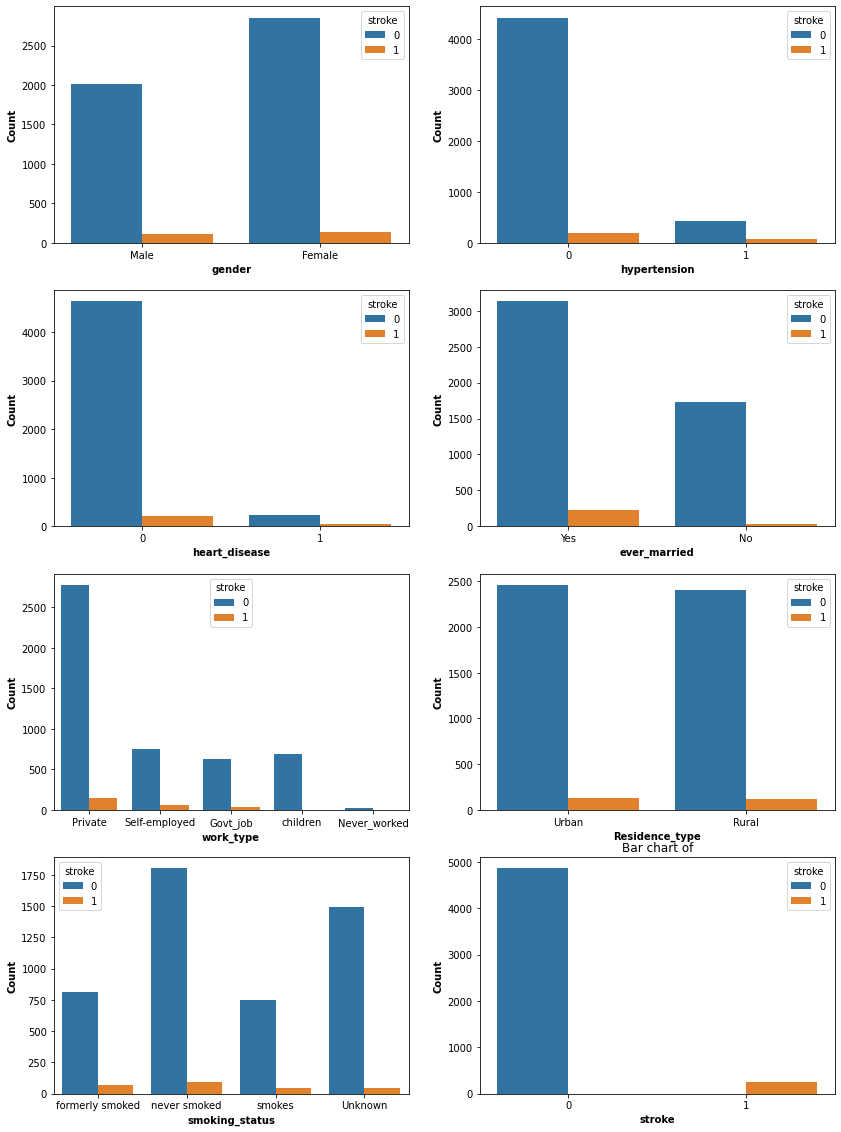

In [12]:
df_cat = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status', 'stroke']

fig, axs = plt.subplots(4,2, figsize=(14,20))
axs = axs.flatten()

for i, col_name in enumerate(df_cat):
    sns.countplot(x=col_name, data=data, ax = axs[i], hue=data['stroke'])
    plt.title('Bar chart of')
    axs[i].set_xlabel(f'{col_name}', weight='bold')
    axs[i].set_ylabel('Count', weight='bold')

Quan sát thấy:
- gender: Không có sự khác biệt nhiều giữa tỉ lệ người bị đột quỵ giữa 2 giới tính.
- hypertension: những người cao huyết áp có nguy cơ cao bị đột quỵ (trên biểu đồ do dữ liệu nhỏ nên đang thể hiện không rõ ràng - quan sát này dựa trên tìm hiểu cá nhân)
- heart_disease: những người được chẩn đoán mắc bệnh tim cũng có nguy cơ cao bị đột quỵ.
- ever_married: những người đã kết hôn có nguy cơ cao bị đột quỵ
- work_type: những người có kinh nghiệm làm việc và các công việc có liên quan đến nhà nước có nguy cơ cao bị đột quỵ, những người chưa đi làm hiếm khi bị đột quỵ.
- residence_type: không có mối liên quan rõ ràng giữa biến này với việc bị đột quỵ.
- smoking_status: Những người từng hút thuốc hoặc đang hút thuốc tăng nguy cơ bị đột quỵ.

## Phân tích biến định lượng

In [13]:
df_num = ['age', 'avg_glucose_level', 'bmi']


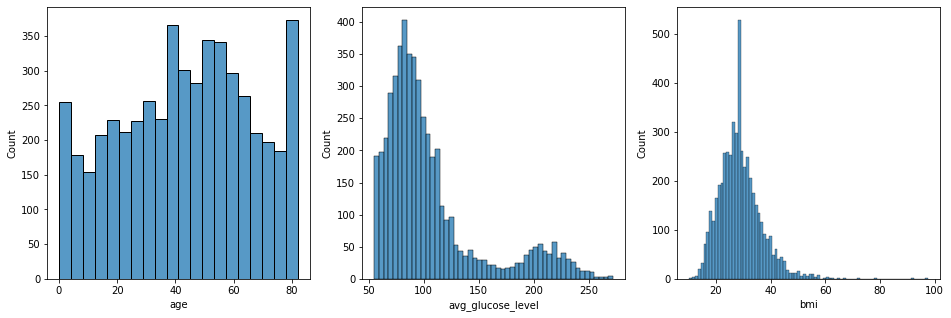

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
axs = axs.flatten()
for i, col_name in enumerate(df_num):
    sns.histplot(data[f'{col_name}'], ax = axs[i])

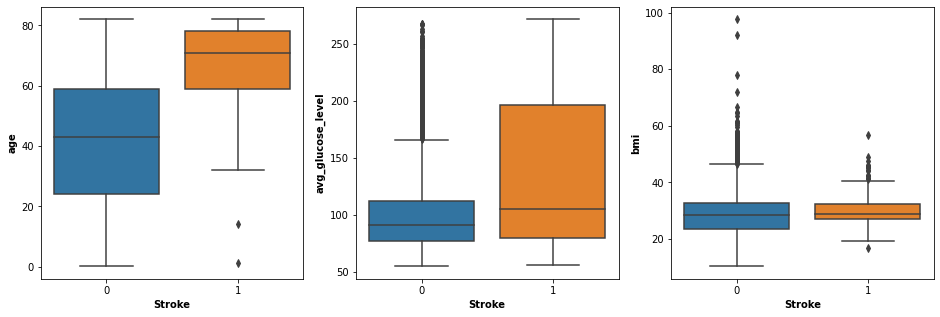

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
axs = axs.flatten()
for i, col_name in enumerate(df_num):
    sns.boxplot(x="stroke", y=col_name, data=data, ax=axs[i])
    axs[i].set_xlabel("Stroke", weight = 'bold')
    axs[i].set_ylabel(f"{col_name}", weight='bold')

Quan sát thấy:
- age: những người bị đột quỵ thường có độ tuổi trung bình cao hơn những người không bị. Những người ở độ tuổi >60 có nguy cơ bị đột quỵ cao hơn. Có 1 vài outlier là những người ở độ tuổi 20 bị đột quỵ, có thể coi là dữ liệu hợp lệ vì đột quỵ còn phụ thuộc vào lối sống và cách ăn uống. Những người không bị đột quỵ đều trong độ tuổi từ 20 - dưới 60.
- avg_glucose_level: những người bị đột quỵ có xu hướng trung bình đường huyết cao hơn những người không bị. Có khá nhiều outliers bệnh nhân không bị đột quỵ.
- bmi: chỉ số bmi không cho biết nhiều về khả năng bị đột quỵ. Tuy nhiên ta thấy có rất nhiều outlier ở biến này. 

In [16]:
bmi_outliers = data.loc[data['bmi'] > 50]
bmi_outliers['bmi'].shape

(79,)

Có tất cả 79 outliers của bmi. Qua tìm hiểu thì thấy chỉ số BMI của những người rất béo phì là 50 -> ta sẽ thay thế các outlier bằng giá trị này.

In [17]:
data['bmi'] = pd.to_numeric(data['bmi'])
data['bmi'] = data['bmi'].apply(lambda x: 50 if x>50 else x)

Text(0.5, 1.0, 'Boxplot of BMI distribution')

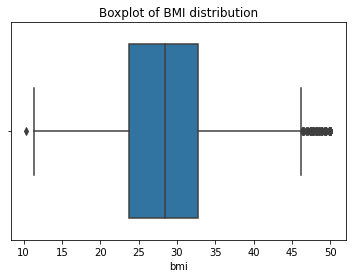

In [18]:
sns.boxplot(data=data, x=data['bmi'])
plt.title('Boxplot of BMI distribution')

In [19]:
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

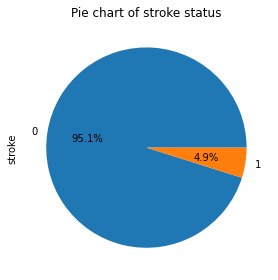

In [20]:
plt.figure(figsize=(4,4))
data['stroke'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Pie chart of stroke status')
plt.tight_layout()

Ta thấy bộ dữ liệu có sự mất cân bằng. Chỉ có 4.9% quan sát trong mẫu đã từng bị đột quỵ.

## Phân tích đa cộng tuyến
Việc phân tích tương quan chỉ chấp nhận các biến định lượng nên ta cần chuyển các biến định tính về các giá trị 0, 1. Ở đây ta dùng LabelEncoder từ thư viện sklearn.preprocessing để làm việc này.

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['gender'] = le.fit_transform(data['gender'])
data['ever_married'] = le.fit_transform(data['ever_married'])
data['work_type'] = le.fit_transform(data['work_type'])
data['Residence_type'] = le.fit_transform(data['Residence_type'])
data['smoking_status'] = le.fit_transform(data['smoking_status'])

df_en = data
df_en.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


<AxesSubplot:>

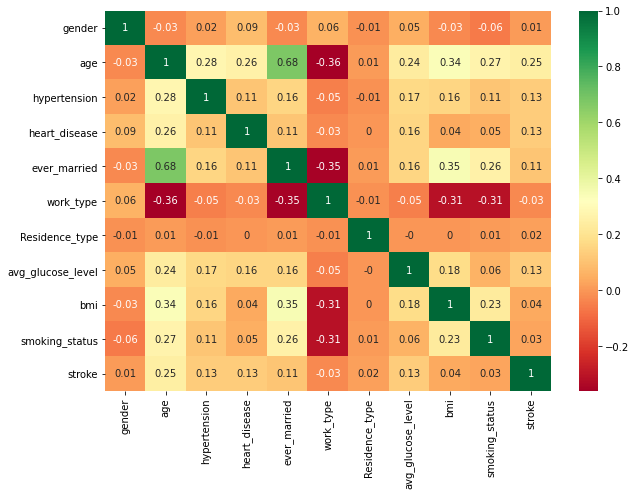

In [22]:
corr = df_en.corr().round(2)
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot = True, cmap = 'RdYlGn')

Từ biểu đồ heatmap ở trên ta thấy có xuất hiện hiện tượng đa cộng tuyến giữa 1 vài biến. VD biến ever_married và age có tương quan 0.68. Giữa 2 biến này ta thấy age có tương quan với stroke cao hơn nên ta sẽ bỏ ever_married.

Đồng thời ta cũng thấy sự tương quan giữa biến phụ thuộc "stroke" với các biến "age", "hypertension", "heart_disease", "avg_glucose_level"

In [23]:
df_en = df_en.drop(['ever_married'], axis = 1)
df_en.head(3)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,2,0,105.92,32.500000,2,1


## Final preprocessing

Các biến được đo lường ở các tỉ lệ khác nhau sẽ không đóng góp như nhau vào việc fitting mô hình, và có thể tạo ra sai lệch. Để giải quyết vấn đề này, ta sử dụng các tiêu chuẩn ($\mu=0, \sigma=1$) để chuẩn hóa lại các tỉ lệ này. Ở đây ta dùng thư viện StandardScaler() cho các biến "avg_glucose_level", "bmi", "age"

In [24]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
cols = ['avg_glucose_level','bmi','age']

std_scaled = s.fit_transform(df_en[cols])

std_scaled = pd.DataFrame(std_scaled, columns=cols)
df_en = df_en.drop(columns=cols, axis=1)
std_scaled.head()

,avg_glucose_level,bmi,age
0,2.706375,1.066746,1.051434
1,2.121559,0.013363,0.786070
2,-0.005028,0.506346,1.626390
3,1.437358,0.766044,0.255342
4,1.501184,-0.655458,1.582163


In [25]:
df = pd.concat([df_en, std_scaled], axis=1)
df.head(3)

,gender,hypertension,heart_disease,work_type,Residence_type,smoking_status,stroke,avg_glucose_level,bmi,age
0,1,0,1,2,1,1,1,2.706375,1.066746,1.051434
1,0,0,0,3,0,2,1,2.121559,0.013363,0.786070
2,1,0,1,2,0,2,1,-0.005028,0.506346,1.626390


# Mô hình hóa



## KMeans implementation

Tuy đã lựa chọn các biến dựa trên correlation ở trên nhưng để chắc chắn, ta sử dụng thư viện SelectKBest, f_classif để đánh lại điểm số mức độ ảnh hưởng của các biến đến biến phụ thuộc, sắp xếp theo thứ tự ảnh hưởng giảm dần.

In [26]:
classifier = SelectKBest(score_func=f_classif,k=5)
fits = classifier.fit(df.drop(['stroke'],axis=1),df['stroke'])
x=pd.DataFrame(fits.scores_)
columns = pd.DataFrame(df.drop('stroke',axis=1).columns)
fscores = pd.concat([columns,x],axis=1)
fscores.columns = ['Attribute','Score']
fscores.sort_values(by='Score',ascending=False)

,Attribute,Score
8,age,326.916568
2,heart_disease,94.698406
6,avg_glucose_level,90.503870
1,hypertension,84.953542
7,bmi,9.541558
3,work_type,5.340019
5,smoking_status,4.043033
4,Residence_type,1.220842
0,gender,0.424625


In [27]:
cols=fscores[fscores['Score']>50].sort_values(by='Score',ascending=False)['Attribute']
# bỏ đi biến ever_married
cols

8                  age
2        heart_disease
6    avg_glucose_level
1         hypertension
Name: Attribute, dtype: object

In [28]:
cols = ['age', 'heart_disease', 'avg_glucose_level', 'hypertension']
# cols = ['age', 'heart_disease', 'avg_glucose_level', 'hypertension','gender','bmi','smoking_status']

In [29]:
train_x,test_x,train_y,test_y=train_test_split(df[cols],df['stroke'],random_state=42,test_size=0.2)
#Splitting data
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((4088, 4), (1022, 4), (4088,), (1022,))

Vì dữ liệu hiện tại mất cân bằng, nên ta sử dụng phương pháp [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) để cân bằng lại dữ liệu. Phương pháp này sẽ phân bố lại dữ liệu với các bản ghi tương đồng với các bản ghi thuộc lớp có số lượng thiểu số.

In [30]:
smote = SMOTE()
train_x, train_y = smote.fit_resample(train_x, train_y)
test_x, test_y = smote.fit_resample(test_x, test_y)

In [31]:
train_x.shape,train_y.shape,test_x.shape,test_y.shape

((7802, 4), (7802,), (1920, 4), (1920,))

In [32]:
df_y_train = pd.DataFrame({'stroke': train_y.values})
df_y_train.head()

,stroke
0,0
1,0
2,0
3,0
4,0


<AxesSubplot:xlabel='stroke', ylabel='count'>

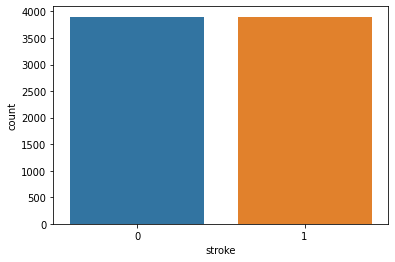

In [33]:
sns.countplot(data=df_y_train, x='stroke')

Để đánh giá được số cụm phù hợp với tập dữ liệu, ở đây ta chạy thuật toán thử nghiệm số lượng cụm từ 1-10, sau đó so sánh SSE (sum-squared-error) (Phương pháp ELBOW).

In [34]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(train_x)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

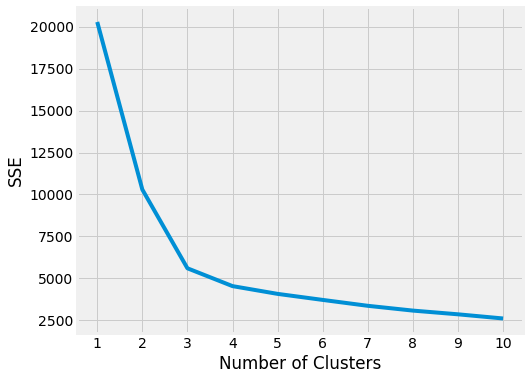

In [35]:
plt.figure(figsize=(8,6))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

Thư viện KneeLocator để tìm ra được điểm elbow point thay vì nhìn bằng mắt thường.

In [36]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

3

Ta thấy sau khi cân bằng lại dữ liệu, với các số cụm <=3 SSE giảm rất nhiều và nhanh. Để phù hợp với bài toán dự đoán 1 bệnh nhân có bị đột quỵ hay không, ta chọn k=2

In [37]:
km = KMeans(n_clusters = 2, n_init=10, random_state=42)
km.fit(train_x, train_y)
y_pred = km.predict(test_x)
arg_test = {'y_true':test_y, 'y_pred':y_pred}
print(' Accuracy: ',accuracy_score(test_y, y_pred).round(4))
print('F1 Score: ',f1_score(test_y, y_pred).round(4))
print(confusion_matrix(**arg_test))
print(classification_report(**arg_test))

 Accuracy:  0.6323
F1 Score:  0.5042
[[855 105]
 [601 359]]
              precision    recall  f1-score   support

           0       0.59      0.89      0.71       960
           1       0.77      0.37      0.50       960

    accuracy                           0.63      1920
   macro avg       0.68      0.63      0.61      1920
weighted avg       0.68      0.63      0.61      1920



## Thử nghiệm với các mô hình

### XGB Classifier

In [38]:
xgc=XGBClassifier(objective='binary:logistic',n_estimators=1000,max_depth=5,learning_rate=0.01,n_jobs=-1)
xgc.fit(train_x,train_y)
predict=xgc.predict(test_x)
print('Accuracy: ',accuracy_score(test_y, predict).round(4))
print('F1 Score: ',f1_score(test_y, predict).round(4))
print('Classification Report: \n', classification_report(test_y, predict))

[11:04:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tm/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy:  0.851
F1 Score:  0.8441
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       960
           1       0.89      0.81      0.84       960

    accuracy                           0.85      1920
   macro avg       0.85      0.85      0.85      1920
weighted avg       0.85      0.85      0.85      1920



### Mô hình khác:
- Decision Tree
- Logistic Regression
- Random Forest
- Support Vector Machine
- kNN
- Naive Bayes
- KMeans

In [39]:
models = dict()
models['Decision Tree'] = DecisionTreeClassifier()
models['Logistic Regression'] = LogisticRegression()
models['Random Forest'] = RandomForestClassifier()
models['Support Vector Machine'] = SVC(kernel = 'sigmoid', gamma='scale', probability=True)
models['kNN'] = KNeighborsClassifier()
models['Naive Bayes'] = GaussianNB()
models['KMeans'] = KMeans(n_clusters=2, n_init=10, random_state=42)

In [40]:
for model in models:
    models[model].fit(train_x, train_y)
    print(model + " model fitting completed.")

Decision Tree model fitting completed.
Logistic Regression model fitting completed.
Random Forest model fitting completed.
Support Vector Machine model fitting completed.
kNN model fitting completed.
Naive Bayes model fitting completed.
KMeans model fitting completed.


In [41]:
print("Test Set Prediction:\n")

for x in models:
    print('-'*20+x+'-'*20)
    model = models[x]
    y_pred = model.predict(test_x)
    arg_test = {'y_true':test_y, 'y_pred':y_pred}
    print('Accuracy: ',accuracy_score(test_y, y_pred).round(4))
    print('F1 Score: ',f1_score(test_y, y_pred).round(4))
    print(confusion_matrix(**arg_test))
    print(classification_report(**arg_test))

Test Set Prediction:

--------------------Decision Tree--------------------
Accuracy:  0.8229
F1 Score:  0.803
[[887  73]
 [267 693]]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       960
           1       0.90      0.72      0.80       960

    accuracy                           0.82      1920
   macro avg       0.84      0.82      0.82      1920
weighted avg       0.84      0.82      0.82      1920

--------------------Logistic Regression--------------------
Accuracy:  0.7677
F1 Score:  0.7727
[[716 244]
 [202 758]]
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       960
           1       0.76      0.79      0.77       960

    accuracy                           0.77      1920
   macro avg       0.77      0.77      0.77      1920
weighted avg       0.77      0.77      0.77      1920

--------------------Random Forest--------------------
Accuracy:  0.7255
F1 Score:  0.6553
[[8

In [42]:
print('Summary of Accuracy Score\n')
for i in models:
    model = models[i]
    print(i + ' Model: ',accuracy_score(test_y, model.predict(test_x)).round(4))

Summary of Accuracy Score

Decision Tree Model:  0.8229
Logistic Regression Model:  0.7677
Random Forest Model:  0.7255
Support Vector Machine Model:  0.7677
kNN Model:  0.6766
Naive Bayes Model:  0.6906
KMeans Model:  0.6323


In [43]:
from sklearn.metrics import plot_roc_curve
from sklearn import metrics

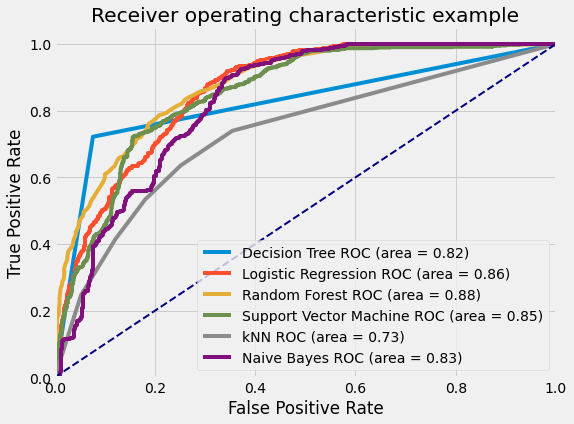

In [44]:
# fig = plt.figure(figsize=(10, 8))
# lw = 2
plt.figure(figsize=(8,6))
# Below for loop iterates through your models list
for i in models:
    if i == 'KMeans':
        continue
    model = models[i] # select the model
    y_pred = model.predict(test_x) # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(test_y, model.predict_proba(test_x)[:,1])
    # Calculate Area under the curve to display on the plot
    # auc = metrics.roc_auc_score(test_y, model.predict(test_x))
    auc_ = metrics.auc(fpr, tpr)
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (i, auc_))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

## Kiểm định chéo (Cross-validation)

In [45]:
from sklearn.model_selection import cross_val_score

gnb = GaussianNB()
dct = DecisionTreeClassifier()
km = KMeans(n_clusters=2, n_init=10, random_state=42)

scores = cross_val_score(dct, train_x, train_y, cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Cross-validation scores:[0.80665813 0.92445583 0.92051282 0.92435897 0.93333333 0.91410256
 0.92179487 0.92692308 0.92051282 0.92820513]
Average cross-validation score: 0.9121


## Kết luận

- Trong các mô hình thử nghiệm, Decision Tree cho kết quả tốt nhất với độ chính xác 80,78%

- Có thể cải tiến được mô hình Decision Tree bằng việc tinh chỉnh siêu tham số, hoặc điều chỉnh ngưỡng xác suất (probability threshold)